In [1]:
# import libraries
import warnings
from pathlib import Path
import subprocess

import nglview as nv
from openbabel import pybel

from opencadd.structure.core import Structure

In [2]:
# filter warnings
warnings.filterwarnings("ignore")
ob_log_handler = pybel.ob.OBMessageHandler()
pybel.ob.obErrorLog.SetOutputLevel(0)

In [3]:
# define paths
HERE = Path(_dh[-1])
DATA = HERE / "1OS5"

In [4]:
# retrieve structure from the Protein Data Bank
pdb_id = "1os5"
structure = Structure.from_pdbid(pdb_id)
# element information maybe missing, but important for subsequent PDBQT conversion
if not hasattr(structure.atoms, "elements"):
    structure.add_TopologyAttr("elements", structure.atoms.types)
structure
# NBVAL_CHECK_OUTPUT

<Universe with 5009 atoms>

In [5]:
# write the protein file to disk
protein = structure.select_atoms("protein")
protein.write(DATA / "1os5protein.pdb")

In [6]:
def pdb_to_pdbqt(pdb_path, pdbqt_path, pH=7.4):
    """
    Convert a PDB file to a PDBQT file needed by docking programs of the AutoDock family.

    Parameters
    ----------
    pdb_path: str or pathlib.Path
        Path to input PDB file.
    pdbqt_path: str or pathlib.path
        Path to output PDBQT file.
    pH: float
        Protonation at given pH.
    """
    molecule = list(pybel.readfile("pdb", str(pdb_path)))[0]
    # add hydrogens at given pH
    molecule.OBMol.CorrectForPH(pH)
    molecule.addh()
    # add partial charges to each atom
    for atom in molecule.atoms:
        atom.OBAtom.GetPartialCharge()
    molecule.write("pdbqt", str(pdbqt_path), overwrite=True)
    return

In [7]:
# convert protein to PDBQT format
pdb_to_pdbqt(DATA / "1os5protein.pdb", DATA / "1os5.pdbqt")

In [8]:
#Canonical SMILES
smiles = "CC1=CC(=C(C=C1N)C(C)(C)C)SC2=C(CC(OC2=O)(CCC3=CC=C(C=C3)O)C4CCCC4)O"

In [9]:
def smiles_to_pdbqt(smiles, pdbqt_path, pH=7.4):
    """
    Convert a SMILES string to a PDBQT file needed by docking programs of the AutoDock family.

    Parameters
    ----------
    smiles: str
        SMILES string.
    pdbqt_path: str or pathlib.path
        Path to output PDBQT file.
    pH: float
        Protonation at given pH.
    """
    molecule = pybel.readstring("smi", smiles)
    # add hydrogens at given pH
    molecule.OBMol.CorrectForPH(pH)
    molecule.addh()
    # generate 3D coordinates
    molecule.make3D(forcefield="mmff94s", steps=10000)
    # add partial charges to each atom
    for atom in molecule.atoms:
        atom.OBAtom.GetPartialCharge()
    molecule.write("pdbqt", str(pdbqt_path), overwrite=True)
    return

In [10]:
# convert the ligand into PDBQT format
smiles_to_pdbqt(smiles, DATA / "1os5ligand.pdbqt")

In [11]:
ligand_resname = "NH1"
ligand = structure.select_atoms(f"resname {ligand_resname}")
pocket_center = (ligand.positions.max(axis=0) + ligand.positions.min(axis=0)) / 2
pocket_size = ligand.positions.max(axis=0) - ligand.positions.min(axis=0) + 5

In [12]:
def run_smina(
    ligand_path, protein_path, out_path, pocket_center, pocket_size, num_poses=10, exhaustiveness=8
):
    """
    Perform docking with Smina.

    Parameters
    ----------
    ligand_path: str or pathlib.Path
        Path to ligand PDBQT file that should be docked.
    protein_path: str or pathlib.Path
        Path to protein PDBQT file that should be docked to.
    out_path: str or pathlib.Path
        Path to which docking poses should be saved, SDF or PDB format.
    pocket_center: iterable of float or int
        Coordinates defining the center of the binding site.
    pocket_size: iterable of float or int
        Lengths of edges defining the binding site.
    num_poses: int
        Maximum number of poses to generate.
    exhaustiveness: int
        Accuracy of docking calculations.

    Returns
    -------
    output_text: str
        The output of the Smina calculation.
    """
    output_text = subprocess.check_output(
        [
            "smina",
            "--ligand",
            str(ligand_path),
            "--receptor",
            str(protein_path),
            "--out",
            str(out_path),
            "--center_x",
            str(pocket_center[0]),
            "--center_y",
            str(pocket_center[1]),
            "--center_z",
            str(pocket_center[2]),
            "--size_x",
            str(pocket_size[0]),
            "--size_y",
            str(pocket_size[1]),
            "--size_z",
            str(pocket_size[2]),
            "--num_modes",
            str(num_poses),
            "--exhaustiveness",
            str(exhaustiveness),
        ],
        universal_newlines=True,  # needed to capture output text
    )
    return output_text

In [14]:
output_text = run_smina(
    DATA / "1os5ligand.pdbqt",
    DATA / "1os5.pdbqt",
    DATA / "1os5docking_poses.sdf",
    pocket_center,
    pocket_size,
)
print(output_text)

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 1901948212

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


In [16]:
def split_sdf_file(sdf_path):
    """
    Split an SDF file into seperate files for each molecule.
    Each file is named with consecutive numbers.

    Parameters
    ----------
    sdf_path: str or pathlib.Path
        Path to SDF file that should be split.
    """
    sdf_path = Path(sdf_path)
    stem = sdf_path.stem
    parent = sdf_path.parent
    molecules = pybel.readfile("sdf", str(sdf_path))
    for i, molecule in enumerate(molecules, 1):
        molecule.write("sdf", str(parent / f"{stem}_{i}.sdf"), overwrite=True)
    return

In [17]:
split_sdf_file(DATA / "1os5docking_poses.sdf")

In [18]:
docking_pose_id = 1
view = nv.show_structure_file(
    str(DATA / f"1os5docking_poses_{docking_pose_id}.sdf"),
    representations=[{"params": {}, "type": "licorice"}],
)
view.add_pdbid(pdb_id)
view

NGLWidget()

In [19]:
view.render_image(trim=True, factor=2);

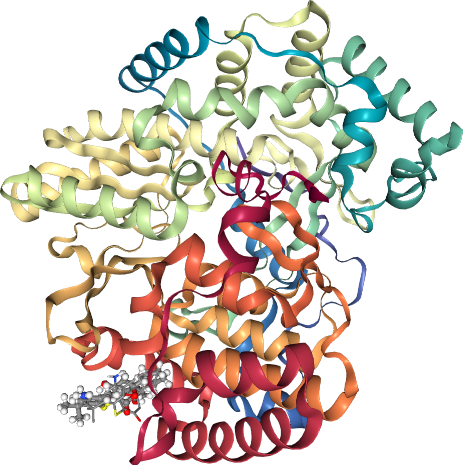

In [20]:
view._display_image()